### Import statements

In [1]:
import cv2
import urllib

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
#from google.colab.patches import cv2_imshow

## Quadtree Object

In [2]:
class Quad:
    def __init__(self, image, render, t, b, l, r):
        # Reference/target image
        self.image = image
        # Image to edit on
        self.render = render

        self.t, self.b, self.l, self.r = t, b, l, r
        self.children = []
        
        self.avg_color = self.image[t:b,l:r].mean(axis=0).mean(axis=0)
        
        # Calculate current error in rendering and gains that could be made with splitting
        self.model_error = self.calculate_error(self.avg_color, self.t, self.b, self.l, self.r)
        self.delta_error = self.calculate_delta_error()
        
        # Draws rectangle into self.render
        self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (self.avg_color[0], self.avg_color[1], self.avg_color[2]), -1)
        # This line adds the box borders
        #self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (0, 0, 0), 1)

    
    def calculate_error(self, avg_color, t, b, l, r):
        error = 0
        
        # If rectangle is too small, return 0 so no benefit in splitting
        if (b-t <= 2 or r-l <= 2):
            return 0

        for row in range(t, b):
            for col in range(l, r):
                blue_error = avg_color[0] - self.image[row, col][0]
                green_error = avg_color[1] - self.image[row, col][1]
                red_error = avg_color[2] - self.image[row, col][2]
#-----------------------------------------------------------------------------------------------------------------
                # Square each of the terms to get better distance calculation / value to optimize
                error += (0.1140*blue_error**2 + 0.5870*green_error**2 + 0.2989*red_error**2)
#-----------------------------------------------------------------------------------------------------------------
        return error
    
    def calculate_delta_error(self):
        new_error = 0
        
        # row and col index to split the Quad
        mh = int(self.t + (self.b - self.t)/2)
        mv = int(self.l + (self.r - self.l)/2)
        
        new_error += self.calculate_error(self.image[self.t:mh, self.l:mv].mean(axis=0).mean(axis=0), self.t, mh, self.l, mv)
        new_error += self.calculate_error(self.image[self.t:mh, mv:self.r].mean(axis=0).mean(axis=0), self.t, mh, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, mv:self.r].mean(axis=0).mean(axis=0), mh, self.b, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, self.l:mv].mean(axis=0).mean(axis=0), mh, self.b, self.l, mv)
        
        return new_error - self.model_error
    
    def split(self):
        if len(self.children) == 0: # No children
            mh = int(self.t + (self.b - self.t)/2)
            mv = int(self.l + (self.r - self.l)/2)
            
            q1 = Quad(self.image, self.render, self.t, mh, self.l, mv)
            q2 = Quad(self.image, self.render, self.t, mh, mv, self.r)
            q3 = Quad(self.image, self.render, mh, self.b, mv, self.r)
            q4 = Quad(self.image, self.render, mh, self.b, self.l, mv)
            
#-----------------------------------------------------------------------------------------------------------------
            # Direct parent Quad to children quads
            self.children = [q1, q2, q3, q4]
#-----------------------------------------------------------------------------------------------------------------
            self.model_error = q1.model_error + q2.model_error + q3.model_error + q4.model_error
            
        else: # Has children
            # Find best Quad to split
            greatest_improvement = self.children[0]
            for child in self.children[1:]:
                if greatest_improvement.delta_error > child.delta_error:
                    greatest_improvement = child

            if greatest_improvement.delta_error < 0:
                self.model_error += greatest_improvement.delta_error
                greatest_improvement.split()
        
        # Update delta_error with delta_error of new children.
        self.delta_error = min([child.delta_error for child in self.children])

In [3]:
path = urllib.request.urlopen(r'https://github.com/BaroqueObama/hhs-ws-quadtrees/blob/main/fr.jpg?raw=true')

In [4]:
def display_image(path):
    arr = np.asarray(bytearray(path.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.title('Image')
    plt.show()

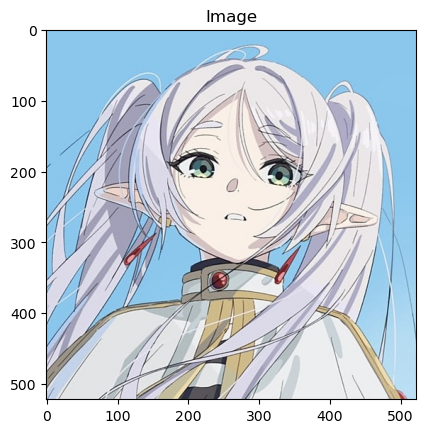

In [5]:
display_image(path)

In [205]:
path = urllib.request.urlopen(r'https://github.com/BaroqueObama/Fun-Datasets/blob/main/images/gateshillman.jpeg?raw=true')

In [187]:
frames = []

In [188]:
#100,000
iterate = [-1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15, 17, 22, 28, 36, 46, 58, 74, 95, 121, 153, 195, 248, 316, 401, 510, 649, 825, 1049, 1333, 1694, 2154, 2738, 3480, 4424, 5623, 7147, 9085, 11547, 14677, 18656, 23713, 30141, 38311, 48696, 61896, 78674, 99999]

In [176]:
len(f)

50

In [150]:
iterate = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 18, 23, 29, 37, 48, 61, 78, 99, 127, 162, 206, 263, 335, 428, 545, 695, 885, 1128, 1438, 1832, 2335, 2976, 3792, 4832, 6157, 7846, 9999]

In [189]:
def make_art(iterations, path):
    # Read in image
    arr = np.asarray(bytearray(path.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    render = image.copy()
    # Instantiate first Quad
    canvas = Quad(image, render, 0, image.shape[0], 0, image.shape[1])
    
    color = cv2.cvtColor(canvas.render, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.savefig(f'gif_img/img_{-1}.png', transparent = False)
    image = imageio.v2.imread(f'gif_img/img_{-1}.png')
    frames.append(image)
    plt.show()
    
    for i in range(iterations):
        canvas.split()
        
        # Rendering
        clear_output(wait = True)
        print(i)
        color = cv2.cvtColor(render, cv2.COLOR_BGR2RGB)
        plt.imshow(color)
        plt.title('Rendered Gates & Hillman Centers')
        
        #plt.pause(0.2)
        
        if i in iterate:

            # GIF Saving
            plt.savefig(f'gif_img/img_{i}.png', transparent = False)


            image = imageio.v2.imread(f'gif_img/img_{i}.png')
            frames.append(image)
        plt.show()
        

In [58]:
import imageio

99999


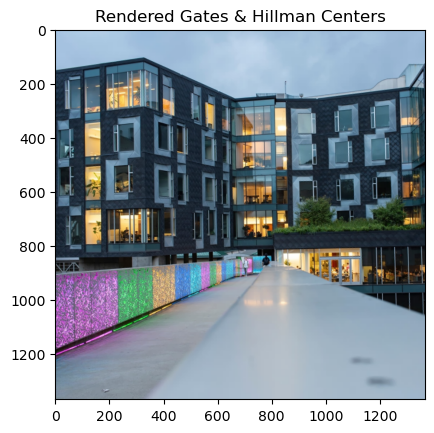

In [190]:
make_art(100000, path)

In [203]:
def make_art(iterations, path):
    # Read in image
    arr = np.asarray(bytearray(path.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    render = image.copy()
    # Instantiate first Quad
    canvas = Quad(image, render, 0, image.shape[0], 0, image.shape[1])
    
    color = cv2.cvtColor(canvas.render, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.title('Rendered Gates & Hillman Centers')
    plt.savefig(f'gif_img/img_{-1}.png', transparent = False)
    image = imageio.v2.imread(f'gif_img/img_{-1}.png')
    
    frames[0]=image
    plt.show()

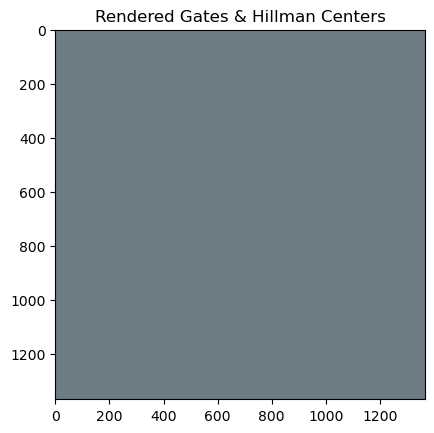

In [206]:
temp = frames[0]
make_art(iterate, path)

In [209]:
imageio.mimsave('Gates&Hillman100000.gif', frames, fps = 5)

In [215]:
x_frames = y_frames.copy()

In [216]:
x_frames = x_frames + x_frames[::-1]

In [217]:
imageio.mimsave('Gates&Hillman100000_extra_reversed.gif', x_frames, fps = 4.5)

In [213]:
y_frames = frames.copy()
y_frames.insert(0, y_frames[0])
y_frames.append(y_frames[-1])

In [214]:
imageio.mimsave('Gates&Hillman100000_extra_start.gif', y_frames, fps = 4.5)

In [108]:
iterate = [-1, 0, 1, 2, 3, 4, 5, 6, 8, 10, 13, 18, 24, 32, 42, 56, 75, 100, 133, 178, 237, 316, 422, 562, 750, 1000, 1334, 1778, 2371, 3162, 4217, 5623, 7499]

In [109]:
bruh = []
for i in iterate:
    image = imageio.v2.imread(f'gif_img/img_{i}.png')
    bruh.append(image)
imageio.mimsave('bruh.gif', frames, fps = 4)

In [9]:
paths = [urllib.request.urlopen(r"https://www.mercurynews.com/wp-content/uploads/2016/08/20150429__ssvs0501toty2.jpg?"), urllib.request.urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/220px-Official_portrait_of_Barack_Obama.jpg"), urllib.request.urlopen(r"https://img1.wsimg.com/isteam/ip/da624b94-4459-4959-bf8d-1abcae1905d2/Herd_It_Here_Photos_AEP%20(247)-0001.JPG"), urllib.request.urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Grevy%27s_Zebra_Stallion.jpg/640px-Grevy%27s_Zebra_Stallion.jpg"), urllib.request.urlopen(r"https://imgs.xkcd.com/comics/digital_data_2x.png")]

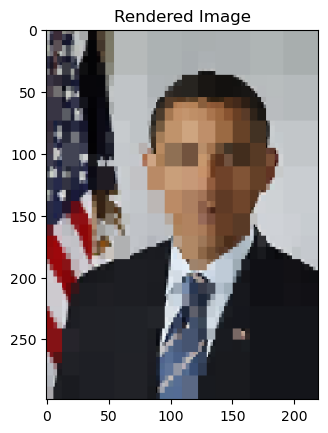

In [11]:
make_art(500, paths[1])

In [222]:
num = 123
digits=[1,2,3]
x = ""
base = 2
if base & (base - 1) == 0: #checking if base is a power of 2 in order to use bitwise operators
    while num:
        remain = num & (base - 1)
        x = digits[remain] + x
        num >>= base.bit_length() - 1
else:
    while num:
        remain = num % base
        x = digits[remain] + x
        num //= base

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [267]:
# Daniel Matsui Smola
# Exercise Encoding

import string # Not used for numeric string processing

# Input num as type int and base as type str
def ConvertBase(num, base):
    # Produces list of strings 0-9 and A-Z
    digits = [str(digit) for digit in range(0,10)] + list(string.ascii_uppercase)
    
    base_int = digits.index(base) # string base as type int
    result = "" # result string where digits will be added onto.
    sign = "-" * (num < 0) # Handles negative numbers
    
    i = num * (1 - 2 * (num < 0)) # Takes absolute value of num
    while i > 0 or not result:
        # Gets digit for remainder and concats to result
        result = digits[int(i % base_int)] + result
        i = int(i // base_int) # Floor divide i by base
    
    return sign + result

In [274]:
ConvertBase(-10, "3")

'-101'